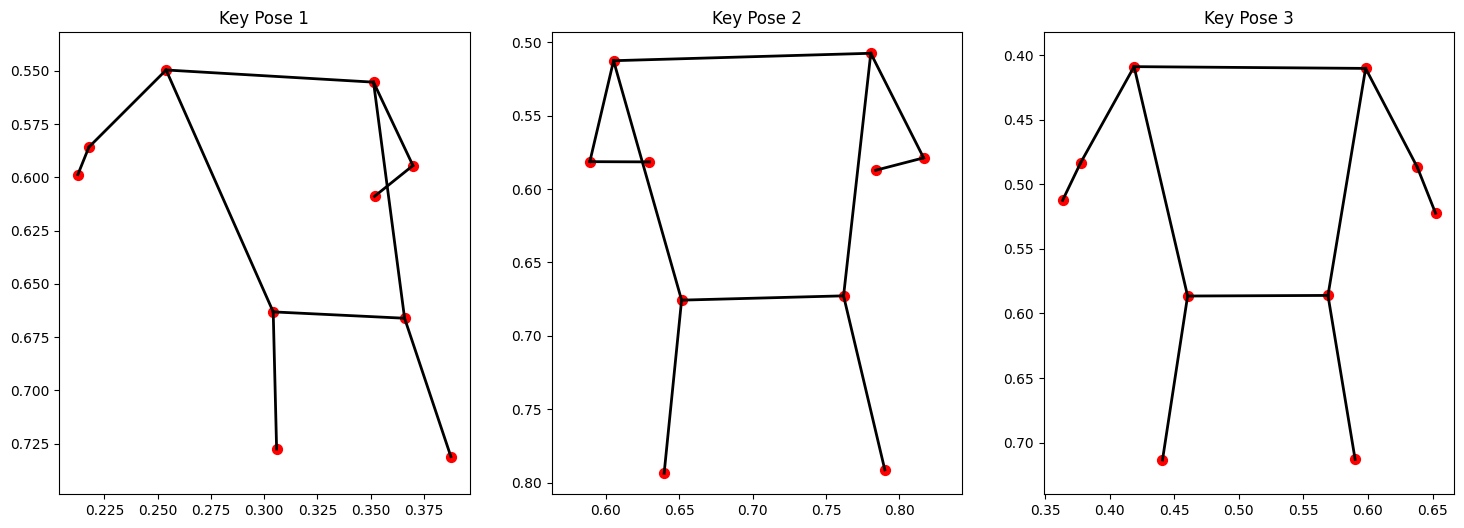

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def remove_outliers(poses, threshold=2.0):
    mean_pose = np.mean(poses, axis=0)
    distances = np.linalg.norm(poses - mean_pose, axis=1)
    valid_indices = distances < (np.mean(distances) + threshold * np.std(distances))
    return poses[valid_indices]

def compute_key_poses(csv_folder, pose_cols, k):
    all_poses = []  

    for filename in os.listdir(csv_folder):
        if filename.endswith('.csv'):
            file_path = os.path.join(csv_folder, filename)
            df = pd.read_csv(file_path)
        
            poses = df[pose_cols].values  
            all_poses.append(poses)

    all_poses_array = np.vstack(all_poses) 
    filtered_poses = remove_outliers(all_poses_array)

    # kmeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(filtered_poses)
    centroids = kmeans.cluster_centers_

    return centroids

def plot_pose(centroid, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 8))
    
    # extract x and y coordinates from the centroid
    xs = centroid[0::2]
    ys = centroid[1::2]
    
    """
      0: left shoulder,
      1: right shoulder,
      2: left elbow,
      3: right elbow,
      4: left wrist,
      5: right wrist,
      6: left hip,
      7: right hip,
      8: left knee,
      9: right knee.
    """
    connections = [
        (0, 1),   # left shoulder to right shoulder
        (0, 2),   # left shoulder to left elbow
        (2, 4),   # left elbow to left wrist
        (1, 3),   # right shoulder to right elbow
        (3, 5),   # right elbow to right wrist
        (0, 6),   # left shoulder to left hip
        (1, 7),   # right shoulder to right hip
        (6, 8),   # left hip to left knee
        (7, 9),   # right hip to right knee
        (6, 7)    # left hip to right hip
    ]
    
    ax.scatter(xs, ys, c='red', s=50, zorder=2)
    
    for i, j in connections:
        if i < len(xs) and j < len(xs):
            ax.plot([xs[i], xs[j]], [ys[i], ys[j]], 'k-', lw=2)
    
    ax.set_title("Key Pose")
    ax.invert_yaxis()  
    ax.axis('equal')


csv_folder = "../rat_dance_csv/train"
pose_cols = []
for i in range(10):
    pose_cols.extend([f"x_pose_{i}", f"y_pose_{i}"])

key_poses = compute_key_poses(csv_folder, pose_cols, 3)
#print(key_poses)
    
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, centroid in enumerate(key_poses):
    plot_pose(centroid, ax=axs[i])
    axs[i].set_title(f"Key Pose {i+1}")
plt.show()

I0000 00:00:1741685303.865574  284465 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3 Pro
W0000 00:00:1741685303.925841  437113 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741685303.933781  437117 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


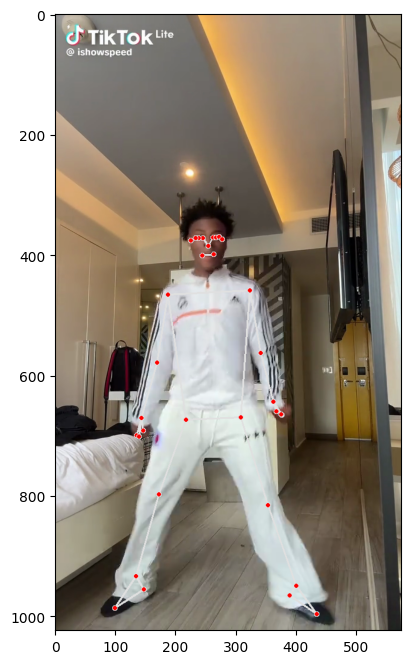

In [ ]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

def extract_frame_from_video(video_path, frame_index):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        print("Failed to extract the frame.")
        return None
    return frame

def overlay_mediapipe_pose(frame):
    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils
    
    with mp_pose.Pose(static_image_mode=True) as pose:
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb_frame)
        if results.pose_landmarks:
            mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
    return frame

csv_path = "speed_nomaxframe.csv"    
video_path = "speed.mp4"    

frame = extract_frame_from_video(video_path, 130) #130, 371, 253
frame_with_pose = overlay_mediapipe_pose(frame.copy())

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(frame_with_pose, cv2.COLOR_BGR2RGB))
plt.show()


I0000 00:00:1741685312.465381  284465 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3 Pro
W0000 00:00:1741685312.524786  437373 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741685312.533052  437383 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


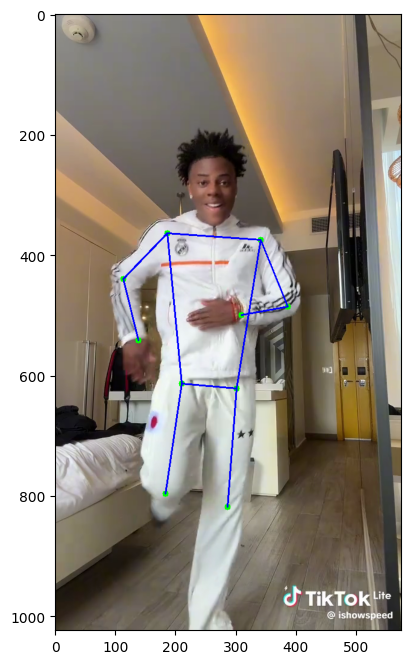

In [ ]:
import cv2
import pandas as pd
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

def extract_frame_from_video(video_path, frame_index):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        print("Failed to extract frame.")
        return None
    return frame

def overlay_custom_pose_with_connections(frame):
    mp_pose = mp.solutions.pose

    with mp_pose.Pose(static_image_mode=True) as pose:
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb_frame)
        
        if results.pose_landmarks:
            key_indices = {
                'LEFT_SHOULDER': mp_pose.PoseLandmark.LEFT_SHOULDER.value,
                'RIGHT_SHOULDER': mp_pose.PoseLandmark.RIGHT_SHOULDER.value,
                'LEFT_ELBOW': mp_pose.PoseLandmark.LEFT_ELBOW.value,
                'RIGHT_ELBOW': mp_pose.PoseLandmark.RIGHT_ELBOW.value,
                'LEFT_WRIST': mp_pose.PoseLandmark.LEFT_WRIST.value,
                'RIGHT_WRIST': mp_pose.PoseLandmark.RIGHT_WRIST.value,
                'LEFT_HIP': mp_pose.PoseLandmark.LEFT_HIP.value,
                'RIGHT_HIP': mp_pose.PoseLandmark.RIGHT_HIP.value,
                'LEFT_KNEE': mp_pose.PoseLandmark.LEFT_KNEE.value,
                'RIGHT_KNEE': mp_pose.PoseLandmark.RIGHT_KNEE.value
            }
            
            height, width, _ = frame.shape
            landmarks = {}

            for name, idx in key_indices.items():
                lm = results.pose_landmarks.landmark[idx]
                x = int(lm.x * width)
                y = int(lm.y * height)
                landmarks[name] = (x, y)
            
            for pt in landmarks.values():
                cv2.circle(frame, pt, radius=5, color=(0, 255, 0), thickness=-2)
            
            connections = [
                ('LEFT_SHOULDER', 'LEFT_ELBOW'),
                ('LEFT_ELBOW', 'LEFT_WRIST'),
                ('RIGHT_SHOULDER', 'RIGHT_ELBOW'),
                ('RIGHT_ELBOW', 'RIGHT_WRIST'),
                ('LEFT_SHOULDER', 'RIGHT_SHOULDER'),
                ('LEFT_SHOULDER', 'LEFT_HIP'),
                ('RIGHT_SHOULDER', 'RIGHT_HIP'),
                ('LEFT_HIP', 'RIGHT_HIP'),
                ('LEFT_HIP', 'LEFT_KNEE'),
                ('RIGHT_HIP', 'RIGHT_KNEE')
            ]
            
            # lines
            for start, end in connections:
                if start in landmarks and end in landmarks:
                    cv2.line(frame, landmarks[start], landmarks[end], color=(255, 0, 0), thickness=2)
    
    return frame

csv_path = "speed_nomaxframe.csv"  
video_path = "speed.mp4"                          
frame = extract_frame_from_video(video_path, 253)
frame_with_pose = overlay_custom_pose_with_connections(frame.copy())
    
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(frame_with_pose, cv2.COLOR_BGR2RGB))
plt.show()
